In [1]:
import pandas as pd

vacc = pd.read_csv("../data/raw/cowin_vaccine_data_statewise.csv")

vacc["date"] = pd.to_datetime(vacc["Updated On"], dayfirst=True)

vacc = vacc[[
    "date", "State",
    "First Dose Administered", "Second Dose Administered",
    "Total Doses Administered"
]]

cases = pd.read_csv("../data/processed/cleaned_case_data.csv")

cases["date"] = pd.to_datetime(cases["Date_YMD"], dayfirst=True)

cases_long = cases.melt(
    id_vars=["date"],
    var_name="state_metric",
    value_name="value"
)

cases_long["State_Code"] = cases_long["state_metric"].str.split("_").str[0]
cases_long["Metric"] = cases_long["state_metric"].str.split("_").str[1]
cases_long = cases_long.drop(columns=["state_metric"])

cases_pivot = cases_long.pivot_table(
    index=["date", "State_Code"],
    columns="Metric",
    values="value",
    aggfunc="first"
).reset_index()

state_map = {
    "AN":"Andaman and Nicobar Islands", "AP":"Andhra Pradesh", "AR":"Arunachal Pradesh", 
    "AS":"Assam", "BR":"Bihar", "CH":"Chandigarh", "CT":"Chhattisgarh", 
    "DL":"Delhi", "DN":"Dadra and Nagar Haveli and Daman and Diu", "GA":"Goa", 
    "GJ":"Gujarat", "HP":"Himachal Pradesh", "HR":"Haryana", "JH":"Jharkhand", 
    "JK":"Jammu and Kashmir", "KA":"Karnataka", "KL":"Kerala", "LA":"Ladakh", 
    "LD":"Lakshadweep", "MH":"Maharashtra", "ML":"Meghalaya", "MN":"Manipur", 
    "MP":"Madhya Pradesh", "MZ":"Mizoram", "NL":"Nagaland", "OR":"Odisha", 
    "PB":"Punjab", "PY":"Puducherry", "RJ":"Rajasthan", "SK":"Sikkim", 
    "TG":"Telangana", "TN":"Tamil Nadu", "TR":"Tripura", "TT":"India", 
    "UP":"Uttar Pradesh", "UT":"Uttarakhand", "WB":"West Bengal"
}

cases_pivot["State"] = cases_pivot["State_Code"].map(state_map)

merged = pd.merge(
    vacc,
    cases_pivot,
    on=["date", "State"],
    how="inner"
)

merged.to_csv("../data/processed/merged_vaccine_cases.csv", index=False)

print("✅ Merged dataset saved as ../data/processed/merged_vaccine_cases.csv")
print(merged.head())

✅ Merged dataset saved as ../data/processed/merged_vaccine_cases.csv
        date           State  First Dose Administered  \
0 2021-01-16  Madhya Pradesh                     9435   
1 2021-01-16     Lakshadweep                       16   
2 2021-01-16     Maharashtra                     5726   
3 2021-01-16         Mizoram                      105   
4 2021-01-16     Uttarakhand                      511   

   Second Dose Administered  Total Doses Administered State_Code Confirmed  \
0                         0                      9435         MP       365   
1                         0                        16         LD         0   
2                         0                      5726         MH      2910   
3                         0                       105         MZ         4   
4                         0                       511         UT       226   

  Deceased Recovered  YMD  
0        5       793  NaN  
1        0         0  NaN  
2       52      3039  NaN  
3      

In [2]:
merged = merged.sort_values(["State", "date"])

for col in ["Confirmed", "Deceased", "Recovered"]:
    merged[col] = pd.to_numeric(merged[col], errors="coerce")

for col in ["First Dose Administered", "Second Dose Administered", "Total Doses Administered"]:
    merged[col] = pd.to_numeric(merged[col], errors="coerce")

for col in ["Confirmed", "Deceased", "Recovered"]:
    merged[f"Daily_{col}"] = merged.groupby("State")[col].diff().fillna(0).astype("Int64")

for col in ["First Dose Administered", "Second Dose Administered", "Total Doses Administered"]:
    merged[f"Daily_{col}"] = merged.groupby("State")[col].diff().fillna(0).astype("Int64")

for col in ["Daily_Confirmed", "Daily_Deceased", "Daily_Recovered", 
            "Daily_First Dose Administered", "Daily_Second Dose Administered"]:
    merged[f"{col}_7dma"] = (
        merged.groupby("State")[col]
        .transform(lambda x: x.rolling(7, min_periods=1).mean())
    )

print("✅ Daily metrics + rolling averages computed")
print(merged.head())

✅ Daily metrics + rolling averages computed
          date                        State  First Dose Administered  \
14  2021-01-16  Andaman and Nicobar Islands                       23   
64  2021-01-17  Andaman and Nicobar Islands                       23   
102 2021-01-18  Andaman and Nicobar Islands                       42   
135 2021-01-19  Andaman and Nicobar Islands                       89   
160 2021-01-20  Andaman and Nicobar Islands                      124   

     Second Dose Administered  Total Doses Administered State_Code  Confirmed  \
14                          0                        23         AN          3   
64                          0                        23         AN          1   
102                         0                        42         AN          5   
135                         0                        89         AN          1   
160                         0                       124         AN          2   

     Deceased  Recovered  YMD  ...  

In [3]:
merged.to_csv("../data/processed/processed_vaccine_cases.csv", index=False)
print("✅ Final processed dataset saved to ../data/processed/processed_vaccine_cases.csv")

✅ Final processed dataset saved to ../data/processed/processed_vaccine_cases.csv


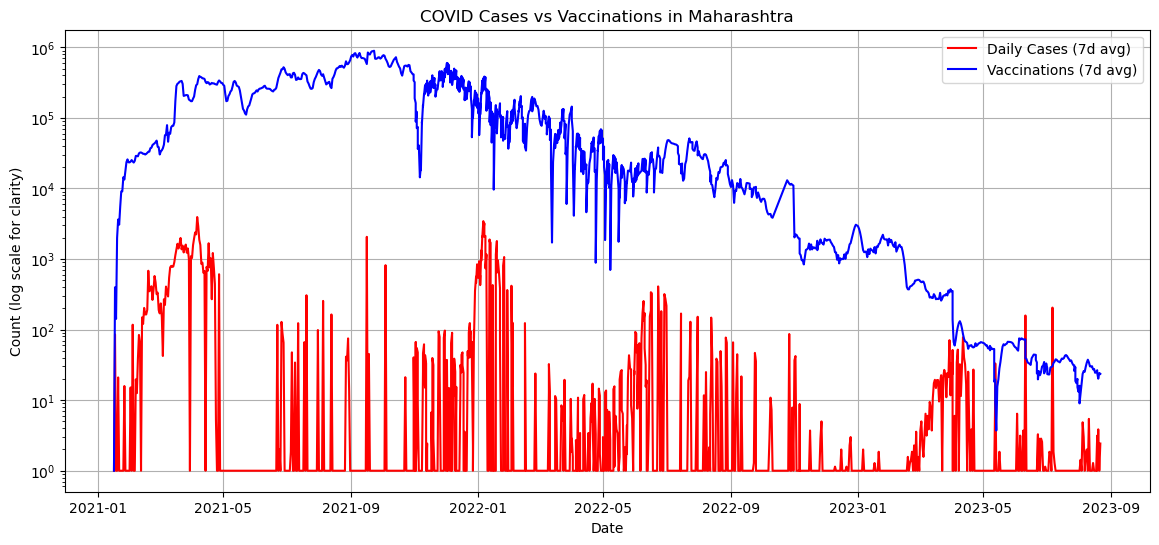

In [4]:
import matplotlib.pyplot as plt

state = "Maharashtra"

final_df = merged.copy()
final_df["Cases_7d_avg"] = final_df["Daily_Confirmed_7dma"]
final_df["Vaccines_7d_avg"] = (
    final_df["Daily_First Dose Administered_7dma"].fillna(0)
    + final_df["Daily_Second Dose Administered_7dma"].fillna(0)
 )

df_state = final_df[final_df["State"] == state].copy()

plt.figure(figsize=(14,6))
plt.plot(df_state["date"], df_state["Cases_7d_avg"].clip(lower=1), label="Daily Cases (7d avg)", color="red")
plt.plot(df_state["date"], df_state["Vaccines_7d_avg"].clip(lower=1), label="Vaccinations (7d avg)", color="blue")
plt.title(f"COVID Cases vs Vaccinations in {state}")
plt.xlabel("Date")
plt.ylabel("Count (log scale for clarity)")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()

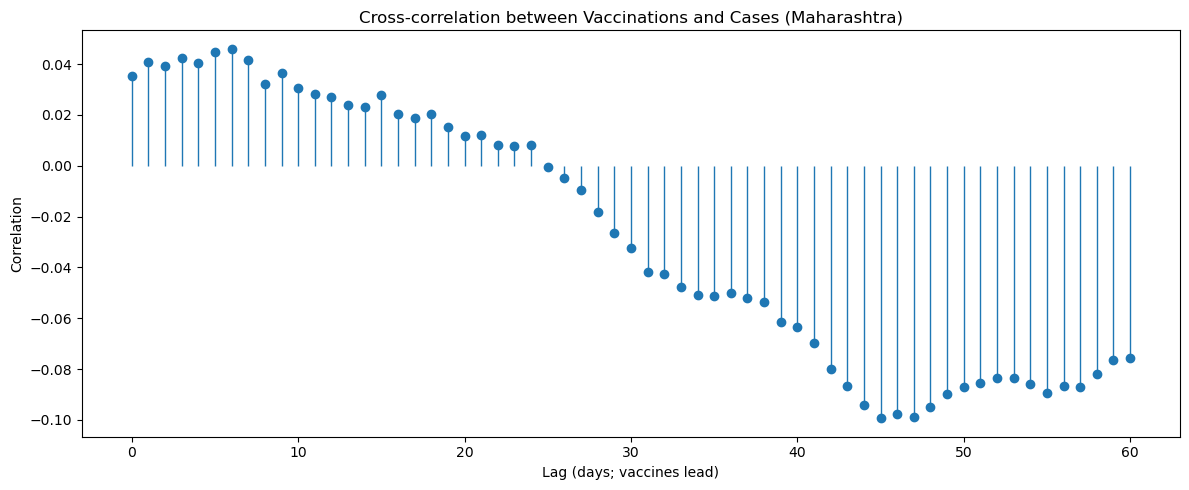

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import ccf

cases = df_state["Cases_7d_avg"].astype(float).to_numpy()
vaccines = df_state["Vaccines_7d_avg"].astype(float).to_numpy()

cases = np.nan_to_num(cases, nan=0.0, posinf=0.0, neginf=0.0)
vaccines = np.nan_to_num(vaccines, nan=0.0, posinf=0.0, neginf=0.0)

n = min(len(cases), len(vaccines))
if n < 3:
    print("Not enough data points for cross-correlation.")
else:
    cases = cases[-n:]
    vaccines = vaccines[-n:]

    cases = cases - cases.mean()
    vaccines = vaccines - vaccines.mean()

    if cases.std(ddof=0) == 0 or vaccines.std(ddof=0) == 0:
        print("Series variance is zero; cross-correlation undefined.")
    else:
        corr = ccf(vaccines, cases)
        max_lag = min(60, len(corr) - 1)
        lags = np.arange(0, max_lag + 1)
        plt.figure(figsize=(12,5))
        markerline, stemlines, baseline = plt.stem(lags, corr[:max_lag+1], basefmt=" ")
        plt.setp(stemlines, linewidth=1)
        plt.title(f"Cross-correlation between Vaccinations and Cases ({state})")
        plt.xlabel("Lag (days; vaccines lead)")
        plt.ylabel("Correlation")
        plt.tight_layout()
        plt.show()

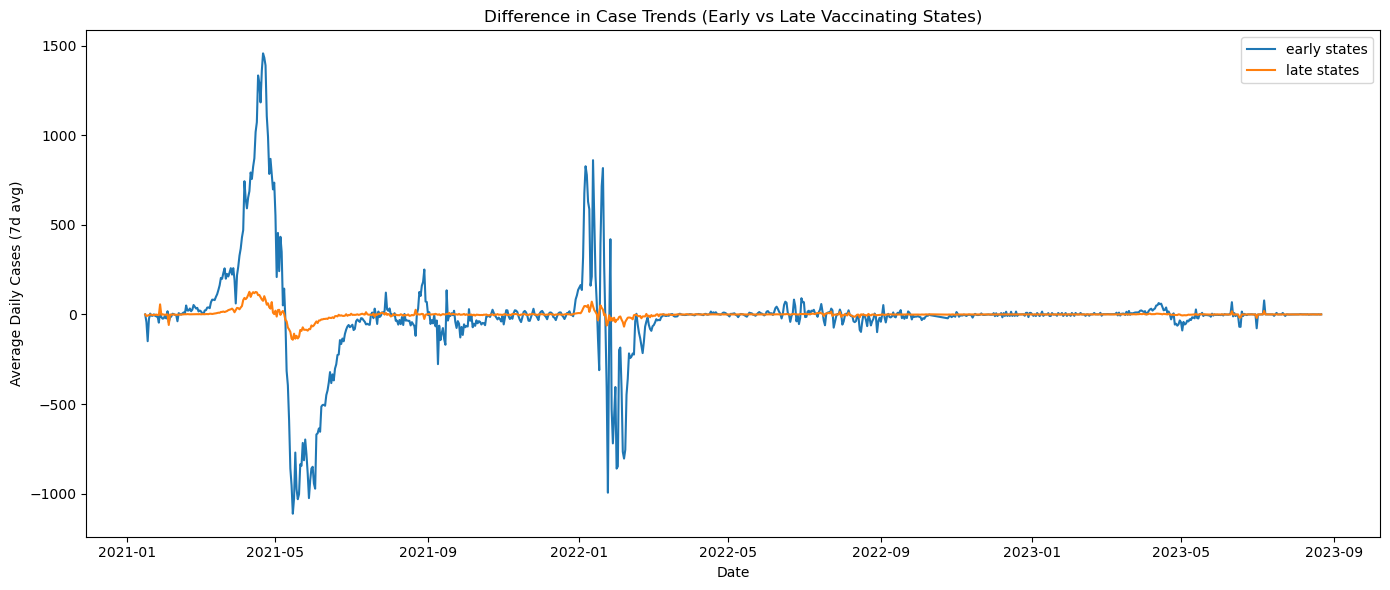

In [6]:
if 'final_df' not in globals():
    final_df = merged.copy()
    final_df["Cases_7d_avg"] = final_df["Daily_Confirmed_7dma"]
    final_df["Vaccines_7d_avg"] = (
        final_df["Daily_First Dose Administered_7dma"].fillna(0)
        + final_df["Daily_Second Dose Administered_7dma"].fillna(0)
    )

mask_vax_start = final_df["Daily_First Dose Administered_7dma"].fillna(0) > 0
first_dose_start = (final_df[mask_vax_start]
                    .groupby("State")["date"].min())

if first_dose_start.empty or first_dose_start.shape[0] < final_df["State"].nunique():
    fallback = final_df.groupby("State")["date"].min()
    first_dose_start = first_dose_start.combine_first(fallback)

median_start = first_dose_start.median()

early_states = first_dose_start[first_dose_start <= median_start].index
late_states = first_dose_start[first_dose_start > median_start].index

final_df["group"] = final_df["State"].apply(lambda x: "early" if x in early_states else "late")

trend = (final_df.groupby(["date", "group"])
         .agg({
             "Cases_7d_avg": "mean",
             "Vaccines_7d_avg": "mean"
         })
         .reset_index())

import matplotlib.pyplot as plt
plt.figure(figsize=(14,6))
for g in ["early", "late"]:
    subset = trend[trend["group"] == g]
    if not subset.empty:
        plt.plot(subset["date"], subset["Cases_7d_avg"], label=f"{g} states")

plt.title("Difference in Case Trends (Early vs Late Vaccinating States)")
plt.xlabel("Date")
plt.ylabel("Average Daily Cases (7d avg)")
plt.legend()
plt.tight_layout()
plt.show()

✅ Lagged correlations computed for all states and saved to ../data/processed/lagged_correlations.csv


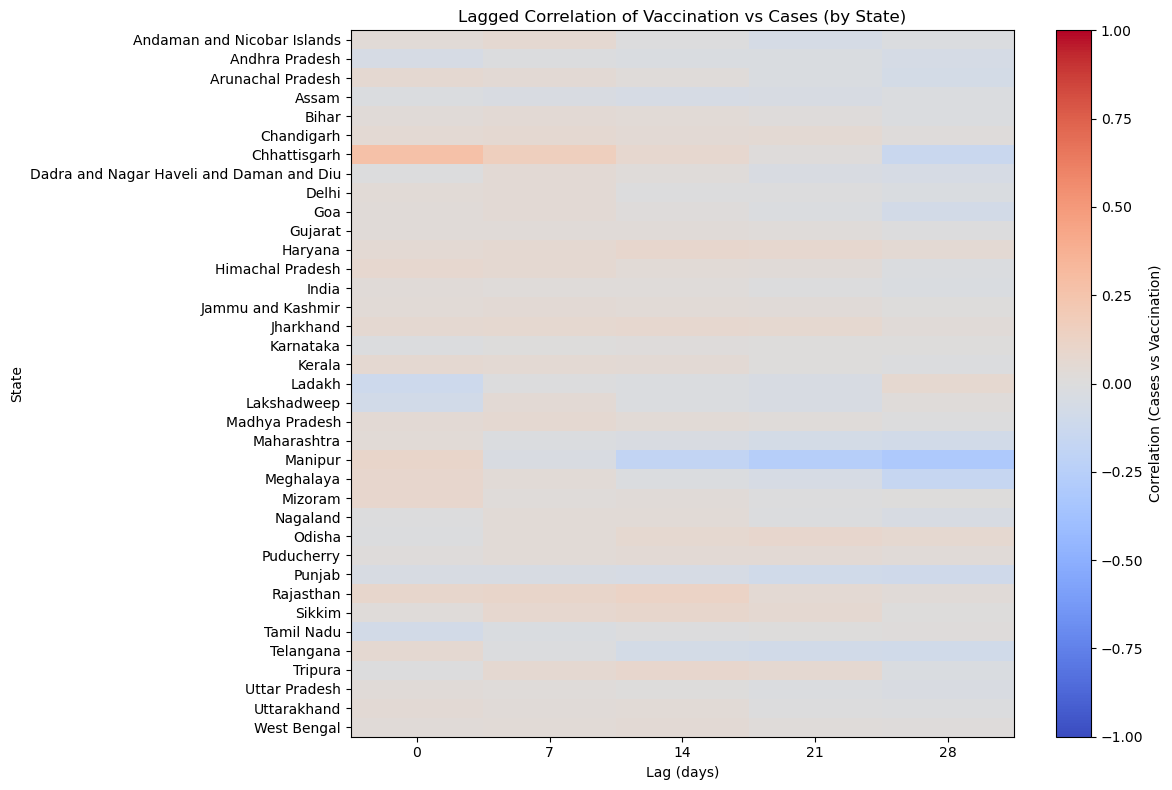

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def compute_lagged_corr(df_state, max_lag=28):
    results = {}
    x = df_state["Cases_7d_avg"].astype(float)
    y_base = df_state["Vaccines_7d_avg"].astype(float)
    for lag in range(0, max_lag + 1, 7):
        y = y_base.shift(lag)
        corr = x.corr(y)
        results[lag] = corr
    return results

if 'final_df' not in globals():
    src = None
    if 'merged' in globals():
        src = merged.copy()
    else:
        try:
            src = pd.read_csv("../data/processed/processed_vaccine_cases.csv", parse_dates=["date"])
        except Exception:
            src = None
    if src is None:
        raise RuntimeError("Required data not available. Run earlier cells to create 'merged' or processed file.")
    final_df = src.copy()
    if "Cases_7d_avg" not in final_df.columns:
        if "Daily_Confirmed_7dma" in final_df.columns:
            final_df["Cases_7d_avg"] = final_df["Daily_Confirmed_7dma"]
        else:
            if "Daily_Confirmed" in final_df.columns:
                final_df["Cases_7d_avg"] = (
                    final_df.groupby("State")["Daily_Confirmed"].transform(
                        lambda x: x.rolling(7, min_periods=1).mean()
                    )
)
            else:
                raise KeyError("Missing columns to compute Cases_7d_avg.")
    if "Vaccines_7d_avg" not in final_df.columns:
        if (
            "Daily_First Dose Administered_7dma" in final_df.columns
            and "Daily_Second Dose Administered_7dma" in final_df.columns
):
            final_df["Vaccines_7d_avg"] = (
                final_df["Daily_First Dose Administered_7dma"].fillna(0)
                + final_df["Daily_Second Dose Administered_7dma"].fillna(0)
)
        elif (
            "Daily_First Dose Administered" in final_df.columns
            and "Daily_Second Dose Administered" in final_df.columns
):
            vax_daily = (
                final_df["Daily_First Dose Administered"].fillna(0)
                + final_df["Daily_Second Dose Administered"].fillna(0)
)
            final_df["Vaccines_7d_avg"] = final_df.groupby("State")[vax_daily.name].transform(
                lambda x: x.rolling(7, min_periods=1).mean()
)
        else:
            raise KeyError("Missing columns to compute Vaccines_7d_avg.")

data = final_df[["State", "date", "Cases_7d_avg", "Vaccines_7d_avg"]].copy()
all_states = data["State"].dropna().unique()
summary_results = []

for state in all_states:
    df_state = data[data["State"] == state].sort_values("date")
    if df_state[["Cases_7d_avg", "Vaccines_7d_avg"]].dropna(how="all").empty:
        continue
    corrs = compute_lagged_corr(df_state)
    for lag, corr in corrs.items():
        summary_results.append({"State": state, "Lag_days": lag, "Correlation": corr})

lag_corr_df = pd.DataFrame(summary_results)
lag_corr_df.to_csv("../data/processed/lagged_correlations.csv", index=False)
print("✅ Lagged correlations computed for all states and saved to ../data/processed/lagged_correlations.csv")

pivot_df = lag_corr_df.pivot(index="State", columns="Lag_days", values="Correlation")

plt.figure(figsize=(12, 8))
im = plt.imshow(pivot_df, cmap="coolwarm", aspect="auto", vmin=-1, vmax=1)
plt.colorbar(im, label="Correlation (Cases vs Vaccination)")
plt.xticks(range(len(pivot_df.columns)), pivot_df.columns)
plt.yticks(range(len(pivot_df.index)), pivot_df.index)
plt.title("Lagged Correlation of Vaccination vs Cases (by State)")
plt.xlabel("Lag (days)")
plt.ylabel("State")
plt.tight_layout()
plt.show()


In [8]:
from scipy.stats import pearsonr

summary_results = []

for state in all_states:
    df_state = data[data["State"] == state].sort_values("date")
    if df_state[["Cases_7d_avg", "Vaccines_7d_avg"]].dropna(how="all").empty:
        continue

    x = df_state["Cases_7d_avg"].astype(float)
    y_base = df_state["Vaccines_7d_avg"].astype(float)

    for lag in range(0, 29, 7):
        y = y_base.shift(lag)
        valid = ~(x.isna() | y.isna())
        if valid.sum() < 10:
            corr, pval = np.nan, np.nan
        else:
            corr, pval = pearsonr(x[valid], y[valid])
        summary_results.append({
            "State": state,
            "Lag_days": lag,
            "Correlation": corr,
            "p_value": pval
        })

lag_corr_signif_df = pd.DataFrame(summary_results)
lag_corr_signif_df.to_csv("../data/processed/lagged_correlations_significance.csv", index=False)

print("✅ Step 6 complete: correlations + p-values saved to ../data/processed/lagged_correlations_significance.csv")

sig_only = lag_corr_signif_df[lag_corr_signif_df["p_value"] < 0.05]
print("Significant correlations found:", len(sig_only))


✅ Step 6 complete: correlations + p-values saved to ../data/processed/lagged_correlations_significance.csv
Significant correlations found: 54


In [9]:
window_sizes = [7, 14]
all_results = []

if 'final_df' not in globals():
    src = None
    if 'merged' in globals():
        src = merged.copy()
    else:
        try:
            src = pd.read_csv("../data/processed/processed_vaccine_cases.csv", parse_dates=["date"])
        except Exception:
            src = None
    if src is None:
        raise RuntimeError("Required data not available. Run earlier cells to create 'merged' or processed file.")
    final_df = src

if "Daily_Confirmed" not in final_df.columns and "Confirmed" in final_df.columns:
    final_df = final_df.sort_values(["State", "date"])
    final_df["Daily_Confirmed"] = final_df.groupby("State")["Confirmed"].diff().fillna(0)

need_vax_daily = ("Daily_First Dose Administered" not in final_df.columns) or ("Daily_Second Dose Administered" not in final_df.columns)
if need_vax_daily and ("First Dose Administered" in final_df.columns and "Second Dose Administered" in final_df.columns):
    final_df = final_df.sort_values(["State", "date"])
    final_df["Daily_First Dose Administered"] = final_df.groupby("State")["First Dose Administered"].diff().fillna(0)
    final_df["Daily_Second Dose Administered"] = final_df.groupby("State")["Second Dose Administered"].diff().fillna(0)

if 'all_states' not in globals():
    all_states = final_df["State"].dropna().unique()

for w in window_sizes:
    temp = final_df.copy()
    if "Daily_Confirmed" not in temp.columns:
        raise KeyError("Daily_Confirmed not found; run earlier cells to compute daily cases.")
    temp["Cases_wavg"] = temp.groupby("State")["Daily_Confirmed"].transform(lambda x: x.rolling(w, min_periods=1).mean())
    temp["Daily_Vaccinations"] = (
        temp["Daily_First Dose Administered"].fillna(0) +
        temp["Daily_Second Dose Administered"].fillna(0)
)
    temp["Vaccines_wavg"] = temp.groupby("State")["Daily_Vaccinations"].transform(lambda x: x.rolling(w, min_periods=1).mean())

    for state in all_states:
        df_state = temp[temp["State"] == state].sort_values("date")
        if df_state[["Cases_wavg", "Vaccines_wavg"]].dropna(how="all").empty:
            continue
        x = df_state["Cases_wavg"].astype(float)
        y_base = df_state["Vaccines_wavg"].astype(float)
        for lag in range(0, 29, 7):
            y = y_base.shift(lag)
            valid = ~(x.isna() | y.isna())
            if valid.sum() < 10:
                corr = np.nan
            else:
                corr = x[valid].corr(y[valid])
            all_results.append({
                "State": state,
                "Window": w,
                "Lag_days": lag,
                "Correlation": corr
            })

robust_df = pd.DataFrame(all_results)
robust_df.to_csv("../data/processed/robustness_check.csv", index=False)
print("✅ Step 7 complete: robustness results saved to ../data/processed/robustness_check.csv")


✅ Step 7 complete: robustness results saved to ../data/processed/robustness_check.csv


In [10]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

if 'final_df' not in globals():
    src = None
    if 'merged' in globals():
        src = merged.copy()
    else:
        try:
            src = pd.read_csv("../data/processed/processed_vaccine_cases.csv", parse_dates=["date"])
        except Exception:
            src = None
    if src is None:
        raise RuntimeError("Required data not available. Run earlier cells to create 'merged' or processed file.")
    final_df = src

if "date" in final_df.columns:
    try:
        final_df["date"] = pd.to_datetime(final_df["date"], errors="coerce")
    except Exception:
        pass

if "Daily_Confirmed" not in final_df.columns and "Confirmed" in final_df.columns:
    final_df = final_df.sort_values(["State", "date"])
    final_df["Daily_Confirmed"] = final_df.groupby("State")["Confirmed"].diff().fillna(0)

need_vax_daily = ("Daily_First Dose Administered" not in final_df.columns) or ("Daily_Second Dose Administered" not in final_df.columns)
if need_vax_daily and ("First Dose Administered" in final_df.columns and "Second Dose Administered" in final_df.columns):
    final_df = final_df.sort_values(["State", "date"])
    final_df["Daily_First Dose Administered"] = final_df.groupby("State")["First Dose Administered"].diff().fillna(0)
    final_df["Daily_Second Dose Administered"] = final_df.groupby("State")["Second Dose Administered"].diff().fillna(0)

final_df["Daily_Vaccinations"] = (
    final_df["Daily_First Dose Administered"].fillna(0) +
    final_df["Daily_Second Dose Administered"].fillna(0)
)

final_df["Cases_7d"] = final_df.groupby("State")["Daily_Confirmed"].transform(lambda x: x.rolling(7, min_periods=1).mean())
final_df["Vax_7d"] = final_df.groupby("State")["Daily_Vaccinations"].transform(lambda x: x.rolling(7, min_periods=1).mean())

final_df["Log_Cases"] = np.log1p(final_df["Cases_7d"].clip(lower=0))
final_df["Log_Vax"] = np.log1p(final_df["Vax_7d"].clip(lower=0))

final_df["Time"] = (final_df["date"] - final_df["date"].min()).dt.days

model = smf.ols(
    formula="Log_Cases ~ Log_Vax + Time + C(State)",
    data=final_df.dropna(subset=["Log_Cases", "Log_Vax"])
).fit(cov_type="HC3")

print(model.summary())

with open("../data/processed/regression_results.txt", "w") as f:
    f.write(model.summary().as_text())

print("✅ Step 8 complete: regression results saved to ../data/processed/regression_results.txt")


                            OLS Regression Results                            
Dep. Variable:              Log_Cases   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     186.7
Date:                Sun, 17 Aug 2025   Prob (F-statistic):               0.00
Time:                        11:41:42   Log-Likelihood:                -90397.
No. Observations:               51245   AIC:                         1.809e+05
Df Residuals:                   51206   BIC:                         1.812e+05
Df Model:                          38                                         
Covariance Type:                  HC3                                         
                                                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

In [11]:
import numpy as np

if "Log_Vax" in model.params:
    coef = model.params["Log_Vax"]
    pval = model.pvalues["Log_Vax"]

    print("\n=== Step 9: Hypothesis Interpretation ===")
    print(f"Coefficient for vaccination (Log_Vax): {coef:.4f}")
    print(f"P-value: {pval:.4e}")

    if coef < 0 and pval < 0.05:
        print("✅ Evidence supports the hypothesis: Higher vaccination is associated with LOWER COVID cases.")
    elif coef > 0 and pval < 0.05:
        print("⚠️ Unexpected: Higher vaccination is associated with HIGHER cases (possible confounding).")
    else:
        print("❌ No statistically significant relationship between vaccination and cases.")
    
    print(f"\nR-squared of model: {model.rsquared:.3f}")
    if model.rsquared < 0.2:
        print("Note: Model explains only a small fraction of variation. Many other factors drive COVID trends.")
    else:
        print("Model explains a meaningful share of variation in cases.")
    
    with open("../data/processed/final_interpretation.txt", "w") as f:
        f.write("=== Step 9: Final Interpretation ===\n")
        f.write(f"Coefficient(Log_Vax): {coef:.4f}\n")
        f.write(f"P-value: {pval:.4e}\n")
        if coef < 0 and pval < 0.05:
            f.write("✅ Evidence supports hypothesis: Vaccination reduces COVID-19 cases.\n")
        elif coef > 0 and pval < 0.05:
            f.write("⚠️ Unexpected: Vaccination appears positively associated with cases.\n")
        else:
            f.write("❌ No significant effect detected.\n")
        f.write(f"Model R-squared: {model.rsquared:.3f}\n")
    
    print("\n📄 Final interpretation saved to ../data/processed/final_interpretation.txt")

else:
    print("Error: Log_Vax coefficient not found in model.")



=== Step 9: Hypothesis Interpretation ===
Coefficient for vaccination (Log_Vax): 0.0211
P-value: 1.8324e-09
⚠️ Unexpected: Higher vaccination is associated with HIGHER cases (possible confounding).

R-squared of model: 0.133
Note: Model explains only a small fraction of variation. Many other factors drive COVID trends.

📄 Final interpretation saved to ../data/processed/final_interpretation.txt
